In [1]:
import pboxplots
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skewnorm
import pickle 
import time

from scipy.stats import t

## Simulation settings

In [2]:
def do_simulation(distribution = 'normal',
                  delta = 0.25, c= 20 ,
                  method_vector = ['PrivateQuantile', 'unbounded', 'JointExp', 'ApproxQuantile', 'DPBoxplot'],
                  eps_vector = ['oracle',0.5, 1, 5, 10],
                  n_vector = [1000, 3500, 10000, 35000, 100000],
                  M = 100):

    if len(method_vector) == 1:
        file_path = 'simulation_results/single_method_' + method_vector[0] + '_' + distribution + '_M' + str(M) + '_delta' + str(int(delta*100)) + '_c' + str(c) + '.pkl'
    else:
        file_path = 'simulation_results/single_' + distribution + '_M' + str(M) + '_delta' + str(int(delta*100)) + '_c' + str(c) + '.pkl'
    
    all_results = []

    if distribution == 'normal':
        x = np.random.standard_normal(size=10000000)

    elif distribution == 'skew':   
        a = 20 
        loc = -1.319
        scale = 1.655 
        x = skewnorm.rvs(a, loc, scale, size=10000000)
    
    elif distribution == 't':
        df = 10
        x = t.rvs(df, size=10000000)
    
    elif distribution == 'uniform':
        low = -np.sqrt(3)
        high = np.sqrt(3)
        x = np.random.uniform(low, high, size=10000000)

    elif distribution == 'airbnb':
        df = pd.read_csv('data/AB_NYC_2019.csv')
        price = []
        for i in df.price:
            if pd.isnull(i):
                price.append(None)
            else:
                price.append(int(i))
        df['price'] = price
        df = df.dropna(subset = 'price')
        x = np.array(list(df.price))
        
        x = (x-np.mean(x))/np.std(x)
        df['price'] = x

    elif distribution == 'beta':
        alpha = 2.0  
        beta = 2.0  

        x = np.random.beta(alpha, beta, size = 1000000)
        x = (x-np.mean(x))/np.std(x)

    bp_base = pboxplots.get_box_plot(x, dp = False)

    for eps in eps_vector:

        for n in n_vector:
            results = {}

            if eps == 'oracle':
                results['oracle'] = []
            else:
                for method in method_vector:
                    results[method] = []

            print([eps, n])

            for i in range(M):

                #np.random.seed(i)

                if distribution == 'normal':
                    x = np.random.standard_normal(size=n)
                elif distribution == 'skew': 
                    x = skewnorm.rvs(a, loc, scale, size=n)
                elif distribution == 't':
                    x = t.rvs(df, size=n)
                elif distribution == 'uniform':
                    x = np.random.uniform(low, high, size=n)
                elif distribution == 'airbnb':
                    x = np.random.choice(df.price, size=n, replace=True)
                elif distribution == 'beta':
                    x = np.random.beta(alpha, beta, size = n)
                    x = (x-np.mean(x))/np.std(x)
                
                if eps!='oracle':
                    
                    for method in method_vector:
                        bp_private = pboxplots.get_box_plot(x, dp = True, eps = eps, method = method, c = c, delta = delta)
                        bp_nonprivate = pboxplots.get_box_plot(x, dp = False, eps = eps, method = method)
                        
                        distances_base = pboxplots.box_plot_distance(bp_private,bp_base)
                        distances = pboxplots.box_plot_distance(bp_private,bp_nonprivate)
                        
                        results[method].append(distances_base + distances)
                else:
                    bp_nonprivate = pboxplots.get_box_plot(x, dp = False)
                    distances = pboxplots.box_plot_distance(bp_nonprivate, bp_base)
                    results['oracle'].append(distances + distances)
            
            if eps != 'oracle':
                for method in method_vector:
                    
                    print('method: '+ method)
                    print(list(np.nanmean(np.array(results[method]), axis = 0))) 

                    all_results.append([eps, n, method, results[method]])
            else:
                print(list(np.nanmean(np.array(results['oracle']), axis = 0))) 
                all_results.append([eps, n, 'oracle', results['oracle']])

    # Open the file in binary write mode
    with open(file_path, 'wb') as file:
        # Dump the data into the file using pickle
        pickle.dump(all_results, file)

## Plotting functions

In [6]:
def plot_results_eps(method = 'DPBoxplot', distributions = ['normal', 'skew', 'uniform', 'airbnb', 'beta'], 
                     delta = 0.25, M = 1000, c = 20,
                    figsize = (10,8)):

    distances = ['location', 'scale', 'skewness', 'tails']

    # Create a subplot grid with shared y-axes for each row
    fig, axs = plt.subplots(len(distances), len(distributions), figsize=figsize,
                        sharey='row', sharex='col') 
    
    
    for idistribution in range(len(distributions)):

        distribution = distributions[idistribution]
        file_path = 'simulation_results/single_' + distribution + '_M' + str(M) + '_delta' + str(int(delta*100)) + '_c' + str(c) + '.pkl'

        with open(file_path, 'rb') as f:
            # Load the data from the pickle file
            data = pickle.load(f)

            all_results = []

        for z in data:
            eps_data = z[0]
            n_data = z[1]
            method_data = z[2]

            if n_data<1000:
                continue

            for i in range(len(z[3])):
                #results = np.mean(np.array(z[3]),axis = 0)
                #results = [eps_data, n_data, method_data] + list(results)
                results = [eps_data, n_data, method_data] + list(z[3][i])
                all_results.append(results)

        df = pd.DataFrame(all_results)
        df.columns = ['eps','n', 'method', 'overall', 'd2', 'scale', 'location', 'skewness', 'tails','d3', 'overall_data', 'd2_data', 'scale_data', 'location_data', 'skewness_data', 'tails_data','d3_data']
        df = df[(df['method'] == method) | (df['method'] == 'oracle')].copy()

        for idistance in range(len(distances)):
            dist = distances[idistance]

            ax = axs[idistance, idistribution]  # Select the appropriate subplot

            if (idistance== 0) and (idistribution==0):
                sns.lineplot(df, x='n',y=dist,hue='eps', ax = ax, markers=True, palette = 'tab10')
                ax.legend(title=r'$\epsilon$')
            else:    
                sns.lineplot(df, x='n',y=dist,hue='eps', markers=True, ax=ax, legend = False, palette = 'tab10')
            

            # Set log scale for both x and y axes
            ax.set_xscale('log')
            if dist != 'd3':
                #ax.set_yscale('log')
                ''

            if idistance == 0:
                ax.set_title(distribution)

            if idistribution == 0:
                ax.set_ylabel(dist)
            else:
                ax.set_ylabel('')

            if idistance == len(distances)-1:
                ax.set_xlabel('n')
            else:
                ax.set_xlabel('')
    plt.tight_layout()

    
    plt.savefig('generated_figures/big_single_plot_eps.pdf')
    plt.show()
    
    
def plot_results_method(eps = 5, distributions = ['normal', 'skew', 'uniform', 'airbnb', 'beta'], delta = 0.25, M = 1000, c = 20,
                       figsize = (12,8)):
    
    distances = ['location', 'scale', 'skewness', 'tails']

    # Create a subplot grid with shared y-axes for each row
    fig, axs = plt.subplots(len(distances), len(distributions), figsize=figsize,
                        sharey='row', sharex='col') 
     
    for idistribution in range(len(distributions)):

        distribution = distributions[idistribution]
        file_path = 'simulation_results/single_' + distribution + '_M' + str(M) + '_delta' + str(int(delta*100)) + '_c' + str(c) + '.pkl'

        with open(file_path, 'rb') as f:
            # Load the data from the pickle file
            data = pickle.load(f)

            all_results = []

        for z in data:
            eps_data = z[0]
            n_data = z[1]
            method_data = z[2]
            
            for i in range(len(z[3])):
                #results = np.mean(np.array(z[3]),axis = 0)
                #results = [eps_data, n_data, method_data] + list(results)
                results = [eps_data, n_data, method_data] + list(z[3][i])
                all_results.append(results)

        df = pd.DataFrame(all_results)
        df.columns = ['eps','n', 'method', 'overall', 'd2', 'scale', 'location', 'skewness', 'tails','d3', 'overall_data', 'd2_data', 'scale_data', 'location_data', 'skewness_data', 'tails_data','d3_data']
        df = df[(df['eps'] == eps) | (df['eps'] == 'oracle')].copy()

        for idistance in range(len(distances)):
            dist = distances[idistance]

            ax = axs[idistance, idistribution]  # Select the appropriate subplot

            if (idistance== 0) and (idistribution==0):
                sns.lineplot(df, x='n',y=dist,hue='method', ax = ax, markers=True, palette = 'tab10')
                ax.legend(title='')
            else:    
                sns.lineplot(df, x='n',y=dist,hue='method', markers=True, ax=ax, legend = False, palette = 'tab10')

            # Set log scale for both x and y axes
            ax.set_xscale('log')
            if dist != 'd3':
                # ax.set_yscale('log')
                ''
            if idistance == 0:
                ax.set_title(distribution)

            if idistribution == 0:
                ax.set_ylabel(dist)
            else:
                ax.set_ylabel('')

            if idistance == len(distances)-1:
                ax.set_xlabel('n')
            else:
                ax.set_xlabel('')
    plt.tight_layout()
    plt.savefig('generated_figures/big_single_plot_methods.pdf')
    plt.show()

def plot_results_parameters(eps = 1, method = 'DPBoxplot', 
                            distributions = ['normal', 'skew', 'uniform', 'airbnb', 'beta'], 
                            cs = [1,20,40], deltas = [0, 0.25, 0.5], M = 1000,
                           figsize = (12,8)):
    
    distances = ['location', 'scale', 'skewness', 'tails']

    # Create a subplot grid with shared y-axes for each row
    fig, axs = plt.subplots(len(distances), len(distributions), figsize=figsize,
                        sharey='row', sharex='col') 
     
    for idistribution in range(len(distributions)):
        
        distribution = distributions[idistribution]
        all_results = []
        
        for idelta in range(len(deltas)):
            delta = deltas[idelta]

            for ic in range(len(cs)):
                c = cs[ic]
                
                file_path = 'simulation_results/single_method_' + method + '_' + distribution + '_M' + str(M) + '_delta' + str(int(delta*100)) + '_c' + str(c) + '.pkl'
        
                with open(file_path, 'rb') as f:
                    # Load the data from the pickle file
                    data = pickle.load(f)
    
                for z in data:
                    eps_data = z[0]
                    n_data = z[1]
                    method_data = z[2]
                    
                    if (method_data!=method) and (method_data!='unbounded_bp'):
                        continue
                    results = np.mean(np.array(z[3]),axis = 0)

                    if delta == -0.5:
                        lambda_n = r'$n^{-1}$'
                    elif delta == 0:
                        lambda_n = r'$n^{-1/2}$'
                    elif delta == 0.25:
                        lambda_n = r'$n^{-1/4}$'
                    elif delta == 0.5:
                        lambda_n = 1

                    for i in range(len(z[3])):
                        #results = np.mean(np.array(z[3]),axis = 0)
                        #results = [eps_data, n_data, method_data] + list(results)
                        results = [eps_data, n_data, method_data, lambda_n, c] + list(z[3][i])
                        all_results.append(results)

        df = pd.DataFrame(all_results)
        df.columns = ['eps','n', 'method', r'$\lambda_n$', 'c', 'overall', 'd2', 'scale', 'location', 'skewness', 'tails','d3', 'overall_data', 'd2_data', 'scale_data', 'location_data', 'skewness_data', 'tails_data','d3_data']
        df = df[(df['eps'] == eps)].copy()

        for idistance in range(len(distances)):
            dist = distances[idistance]

            ax = axs[idistance, idistribution]  # Select the appropriate subplot

            if (idistance== 0) and (idistribution==0):
                sns.lineplot(df, x='n',y=dist,hue=r'$\lambda_n$', style = 'c', ax = ax, markers=True, palette = 'tab10')
                ax.legend(title='')
            else:    
                sns.lineplot(df, x='n',y=dist,hue=r'$\lambda_n$', style = 'c', markers=True, ax=ax, legend = False, palette = 'tab10')

            # Set log scale for both x and y axes
            ax.set_xscale('log')
            if dist != 'd3':
                #ax.set_yscale('log')
                ''
            if idistance == 0:
                ax.set_title(distribution)

            if idistribution == 0:
                ax.set_ylabel(dist)
            else:
                ax.set_ylabel('')

            if idistance == len(distances)-1:
                ax.set_xlabel('n')
            else:
                ax.set_xlabel('')
    plt.tight_layout()
    plt.savefig('generated_figures/big_single_plot_parameters.pdf')
    plt.show()

def plot_results_single(distributions = ['normal', 'skew', 'uniform'], 
                        eps_list = [1,5,  'oracle'], 
                        method_list = ['JointExp','ApproxQuantile', 'unbounded', 'PrivateQuantile', 'DPBoxplot', 'oracle'],
                        M=1000, delta=0.25, c = 20,
                       figsize = (12,8)):
    
    legend_handles = []
    distances = ['location', 'scale', 'skewness', 'tails']

    # Create a subplot grid with shared y-axes for each row
    fig, axs = plt.subplots(len(distributions), len(distances), figsize=figsize,
                        sharex='col', sharey = 'col') 
    
    
    for idistribution in range(len(distributions)):

        distribution = distributions[idistribution]
        file_path = 'simulation_results/single_' + distribution + '_M' + str(M) + '_delta' + str(int(delta*100)) + '_c' + str(c) + '.pkl'

        with open(file_path, 'rb') as f:
            # Load the data from the pickle file
            data = pickle.load(f)

            all_results = []

        for z in data:
            eps_data = z[0]
            n_data = z[1]
            method_data = z[2]

            for i in range(len(z[3])):
                #results = np.mean(np.array(z[3]),axis = 0)
                #results = [eps_data, n_data, method_data] + list(results)
                results = [eps_data, n_data, method_data] + list(z[3][i])
                all_results.append(results)
            
        df = pd.DataFrame(all_results)
        df.columns = ['eps','n', 'method', 'overall', 'd2', 'scale', 'location', 'skewness', 'tails','d3', 'overall_data', 'd2_data', 'scale_data', 'location_data', 'skewness_data', 'tails_data','d3_data']
        
        df = df[(df['method'].isin(method_list)) & (df['eps'].isin(eps_list))].copy()
        
        # Convert the 'priority' column to a categorical type with the specified order
        df['method'] = pd.Categorical(df['method'], categories=method_list, ordered=True)
        df['eps'] = [1 if i == 'oracle' else i for i in df['eps']]

        eps_dict = {'oracle':3, 1:1, 2:2}
        for idistance in range(len(distances)):
            dist = distances[idistance]

            ax = axs[idistribution, idistance]  # Select the appropriate subplot

            if (idistance== 2) and (idistribution==0):
                sns.lineplot(df, x='n', y=dist, hue='method', style='eps', markers=True, ax=ax, palette='tab10', linewidth=1)
                handles, labels = ax.get_legend_handles_labels()  # Get legend handles and labels
                legend_handles.extend(handles)  # Add handles to the custom legend list
                #labels = [label if label != 'oracle' else r'$\epsilon$ = oracle' for label in labels]  # Replace 'oracle' label
                ax.legend(handles=[legend_handles[i] for i in [1,2,3,4,5,6,8,9]], labels=[labels[i] for i in [1,2,3,4,5,6,8,9]])
                print(labels)
            else:    
                sns.lineplot(df, x='n',y=dist, hue='method', style = 'eps', markers=True, ax=ax, legend = False, palette = 'tab10', linewidth=1)
            

            # Set log scale for both x and y axes
            ax.set_xscale('log')
            if dist != 'd3':
                #ax.set_yscale('log')
                ''
            if idistance == 0:
                ax.set_ylabel(distribution + ' distribution')
               
            else:
                ax.set_ylabel('')
                
            if idistribution == 0:
                ax.set_title(dist) 
                #ax.set_ylim([0.0001,10])
                
            

            if idistribution == len(distributions)-1:
                ax.set_xlabel('n')
            else:
                ax.set_xlabel('')
    
    plt.subplots_adjust(hspace=-.5)
    plt.tight_layout()

    plt.savefig('generated_figures/single_plot_' + 'M' + str(M) + '_delta' + str(int(delta*100)) + '.pdf')
    plt.show()


def plot_results_slides(distributions = ['skew'], 
                        eps_list = [1,5,  'oracle'], 
                        method_list = ['JointExp','ApproxQuantile', 'unbounded', 'PrivateQuantile', 'DPBoxplot', 'oracle'],
                        M=1000, delta=0.25, c = 20,
                       figsize = (8,8)):
    
    legend_handles = []
    distances = ['location', 'scale', 'skewness', 'tails']

    # Create a subplot grid with shared y-axes for each row
    fig, axs = plt.subplots(2,2, figsize=figsize)
                        #sharex='col', sharey = 'col') 
    
    

    distribution = distributions[0]
    file_path = 'simulation_results/single_' + distribution + '_M' + str(M) + '_delta' + str(int(delta*100)) + '_c' + str(c) + '.pkl'

    with open(file_path, 'rb') as f:
        # Load the data from the pickle file
        data = pickle.load(f)

        all_results = []

    for z in data:
        eps_data = z[0]
        n_data = z[1]
        method_data = z[2]

        for i in range(len(z[3])):
            #results = np.mean(np.array(z[3]),axis = 0)
            #results = [eps_data, n_data, method_data] + list(results)
            results = [eps_data, n_data, method_data] + list(z[3][i])
            all_results.append(results)
        
    df = pd.DataFrame(all_results)
    df.columns = ['eps','n', 'method', 'overall', 'd2', 'scale', 'location', 'skewness', 'tails','d3', 'overall_data', 'd2_data', 'scale_data', 'location_data', 'skewness_data', 'tails_data','d3_data']
    
    df = df[(df['method'].isin(method_list)) & (df['eps'].isin(eps_list))].copy()
    
    # Convert the 'priority' column to a categorical type with the specified order
    df['method'] = pd.Categorical(df['method'], categories=method_list, ordered=True)
    df['eps'] = [1 if i == 'oracle' else i for i in df['eps']]

    eps_dict = {'oracle':3, 1:1, 2:2}
    
    for idistance in range(len(distances)):
        dist = distances[idistance]

        ax = axs[int(idistance/2), idistance%2]  # Select the appropriate subplot

        if (idistance== 3):
            sns.lineplot(df, x='n', y=dist, hue='method', style='eps', markers=True, ax=ax, palette='tab10', linewidth=1)
            handles, labels = ax.get_legend_handles_labels()  # Get legend handles and labels
            legend_handles.extend(handles)  # Add handles to the custom legend list
            #labels = [label if label != 'oracle' else r'$\epsilon$ = oracle' for label in labels]  # Replace 'oracle' label
            ax.legend(handles=[legend_handles[i] for i in [1,2,3,4,5,6,8,9]], labels=[labels[i] for i in [1,2,3,4,5,6,8,9]])
            print(labels)
        else:    
            sns.lineplot(df, x='n',y=dist, hue='method', style = 'eps', markers=True, ax=ax, legend = False, palette = 'tab10', linewidth=1)
        

        # Set log scale for both x and y axes
        ax.set_xscale('log')
        if dist != 'd3':
            #ax.set_yscale('log')
            ''
        if idistance %2 == 0:
            ax.set_ylabel('distance')
           
        else:
            ax.set_ylabel('')
            
        ax.set_title(dist) 
            
        

        if int(idistance/2)==1:
            ax.set_xlabel('n')
        else:
            ax.set_xlabel('')
    
    plt.subplots_adjust(hspace=-.5)
    plt.tight_layout()

    plt.savefig('generated_figures/single_plot_slides_' + 'M' + str(M) + '_delta' + str(int(delta*100)) + '.pdf')
    plt.show()

# SIMULATIONS

In [4]:
#main simulation
start_time = time.time()
M = 1000
for distribution in ['beta','airbnb']:
    print('#################################################')
    print(distribution)
    do_simulation(distribution, M=M)
print(time.time()-start_time)

#################################################
beta
['oracle', 1000]
[0.20961588802838446, 0.21974004787213947, 0.030150685234552256, 0.021094763377973193, 0.15787117912759346, 0.0, 0.0, 0.20961588802838446, 0.21974004787213947, 0.030150685234552256, 0.021094763377973193, 0.15787117912759346, 0.0, 0.0]
['oracle', 3500]
[0.1074053023618166, 0.11400333532451831, 0.01604905297906504, 0.01155371190955465, 0.07991194975940799, 0.0, 0.0, 0.1074053023618166, 0.11400333532451831, 0.01604905297906504, 0.01155371190955465, 0.07991194975940799, 0.0, 0.0]
['oracle', 10000]
[0.06268966212022398, 0.06643701817215958, 0.009768571475049708, 0.006779883111718556, 0.04680829069418193, 0.0, 0.0, 0.06268966212022398, 0.06643701817215958, 0.009768571475049708, 0.006779883111718556, 0.04680829069418193, 0.0, 0.0]
['oracle', 35000]
[0.031199146449527843, 0.03372927170193919, 0.005025257877361674, 0.003775513545554577, 0.023085545663077307, 0.0, 0.0, 0.031199146449527843, 0.03372927170193919, 0.00502525787

C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\joint_exp.py:117: RuntimeWarning: divide by zero encountered in log
  log_alpha = np.log(np.zeros([num_quantiles, num_intervals, num_quantiles]))
C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\joint_exp.py:96: RuntimeWarning: divide by zero encountered in log
  np.log(y, out=y)


method: PrivateQuantile
[2.5749771675481337, 2.5670815688940145, 0.29786836677408085, 0.07317882988331442, 1.9789751301336167, 0.061842393839564344, 0.00225, 2.7023105446561093, 2.696438272435629, 0.2962922171238548, 0.07023457577598778, 2.1078371665201012, 0.061842393839564344, 0.00225]
method: unbounded
[1.1064680022799003, 1.114753615850056, 0.1338766795756542, 0.08241038010078011, 0.8585897838585665, 0.006863082091799313, 0.0, 1.0057706186760769, 1.018415262628533, 0.13126309919164492, 0.07915147844148447, 0.768081309163824, 0.006863082091799313, 0.0]
method: JointExp
[1.843368321154699, 1.8252546190734864, 0.040397579409442226, 0.03346473589562235, 1.7451718543349635, 0.06119831351871467, 0.0, 1.9570856878154956, 1.9314201915349924, 0.029337507963522344, 0.025844541766165612, 1.8757850445372501, 0.06119831351871467, 0.0]
method: ApproxQuantile
[1.8564472326959185, 1.836086732038145, 0.050527386147310546, 0.0337540163529113, 1.7465310521772015, 0.06288206610714722, 0.0, 1.971307888

C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\joint_exp.py:116: RuntimeWarning: divide by zero encountered in log
  data_intervals_log_sizes = np.log(data_intervals[:, 1] - data_intervals[:, 0])
C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\joint_exp.py:117: RuntimeWarning: divide by zero encountered in log
  log_alpha = np.log(np.zeros([num_quantiles, num_intervals, num_quantiles]))
C:\Users\jdiazrod\York University\Kelly Ramsay - Private Boxplots\clean code\private_quantiles\joint_exp.py:96: RuntimeWarning: divide by zero encountered in log
  np.log(y, out=y)


method: PrivateQuantile
[3.7708058619492024, 3.7690413531879763, 1.0488055933782119, 0.02453335247318005, 1.6608134176657752, 0.06884970167197386, 0.01575, 3.8034586419704834, 3.810420606843155, 1.0434408534959398, 0.0239311833333525, 1.7070213808111492, 0.06830830519623002, 0.0155]
method: unbounded
[0.3968771279101383, 0.3741034577988686, 0.06957844573003091, 0.03526889100446788, 0.2530649240374945, 0.04098316707291343, 0.0, 0.3575813133964429, 0.35603542922382503, 0.06027488736663925, 0.038162455452186106, 0.2204361840291904, 0.04028126308352865, 0.0]
method: JointExp
[0.5133870903216178, 0.49894728737754307, 0.025579707687063517, 0.017046081897296624, 0.436937158211203, 0.06317372221978215, 0.0, 0.5295075502452136, 0.5207701195473461, 0.015439054861068648, 0.013490054659279067, 0.4788745813752987, 0.06284541244531297, 0.0]
method: ApproxQuantile
[0.5163122976707629, 0.5042039461320148, 0.02694070822453155, 0.01709401418803787, 0.4369472969384506, 0.06310451792033729, 0.0, 0.5363335

In [ ]:
#changing delta
deltas = [-0.5, 0, 0.25, 0.5]
cs = [1, 20, 40]
start_time = time.time()
M = 1000
for distribution in ['normal', 'skew', 'uniform', 'airbnb', 'beta']:
    print('#################################################')
    print(distribution)
    
    for c in cs:
        for delta in deltas:    
            do_simulation(distribution, delta = delta, c= c, method_vector = ['DPBoxplot'], eps_vector = ['oracle', 1], M = M)

print(time.time()-start_time)

['method', 'JointExp', 'ApproxQuantile', 'unbounded', 'PrivateQuantile', 'DPBoxplot', 'oracle', 'eps', '1', '5']


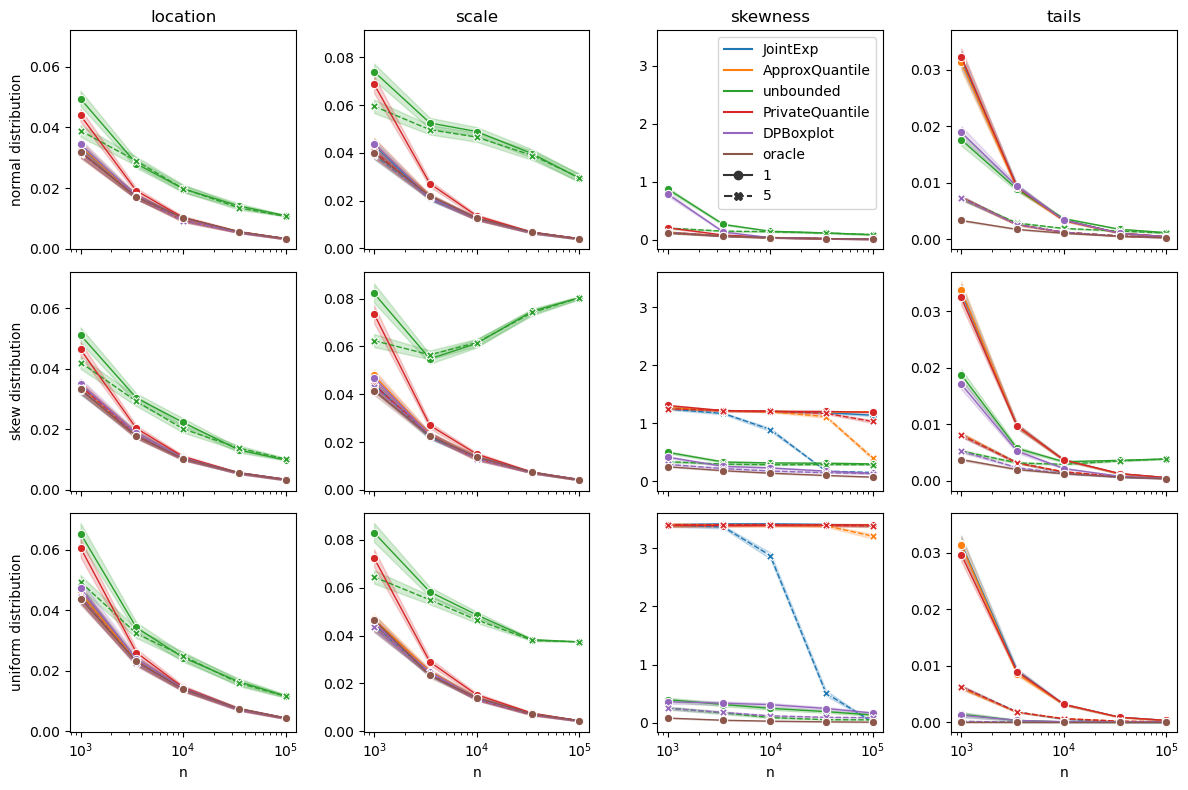

In [32]:
plot_results_single()

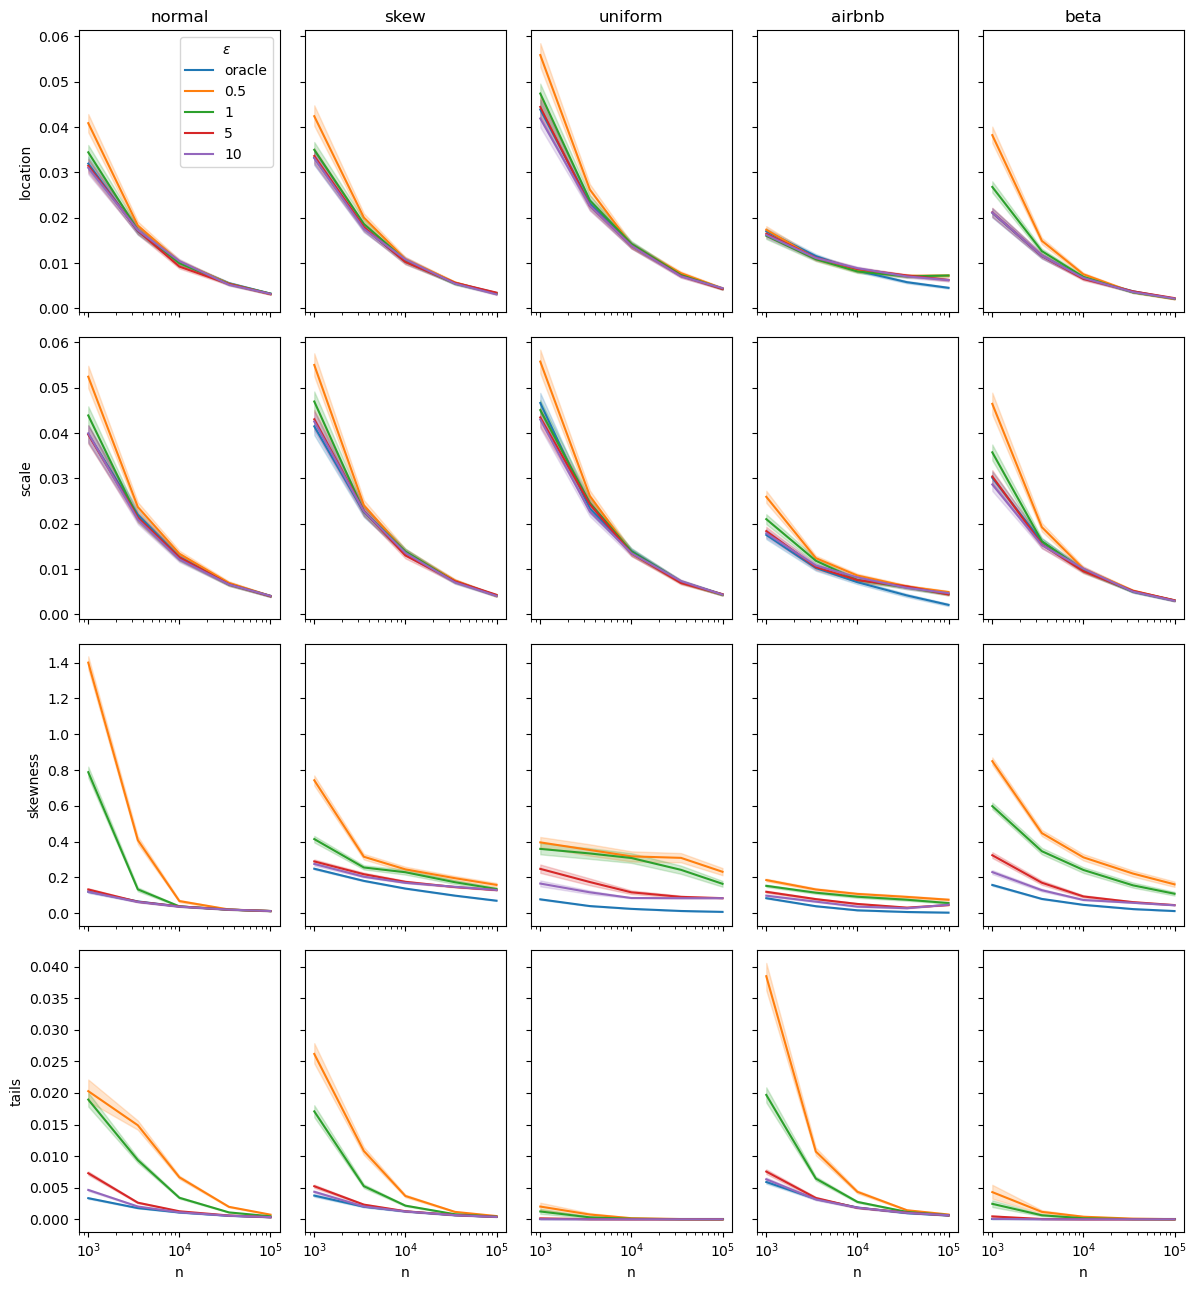

In [33]:
plot_results_eps(figsize = (12,13))

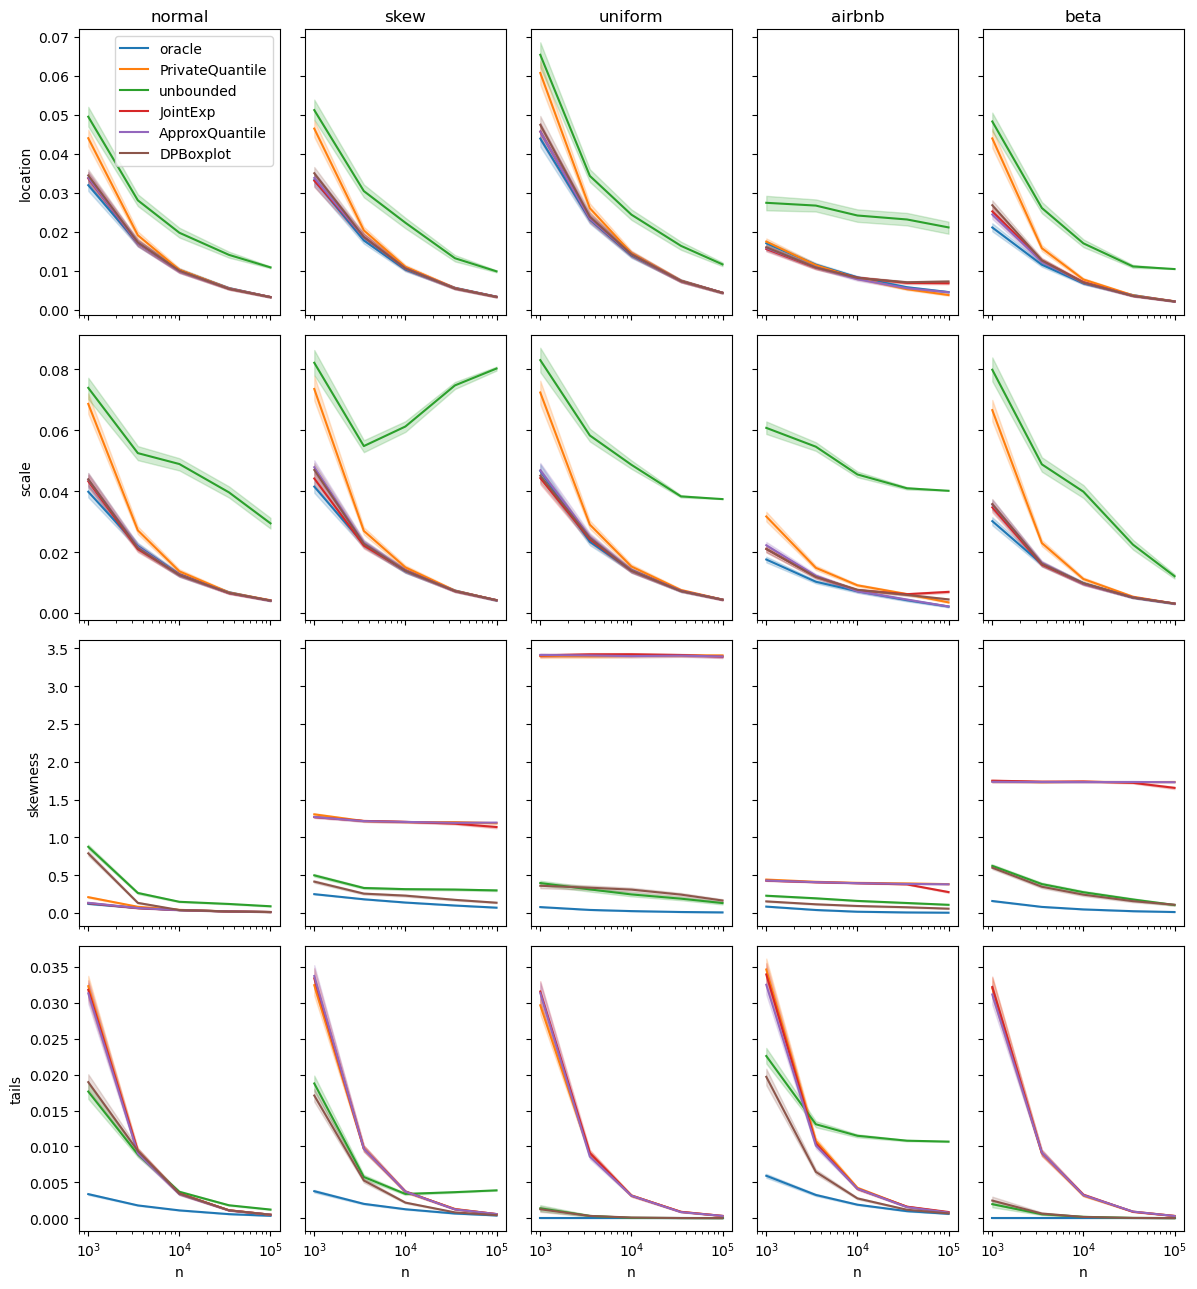

In [34]:
plot_results_method(eps = 1, figsize = (12,13))

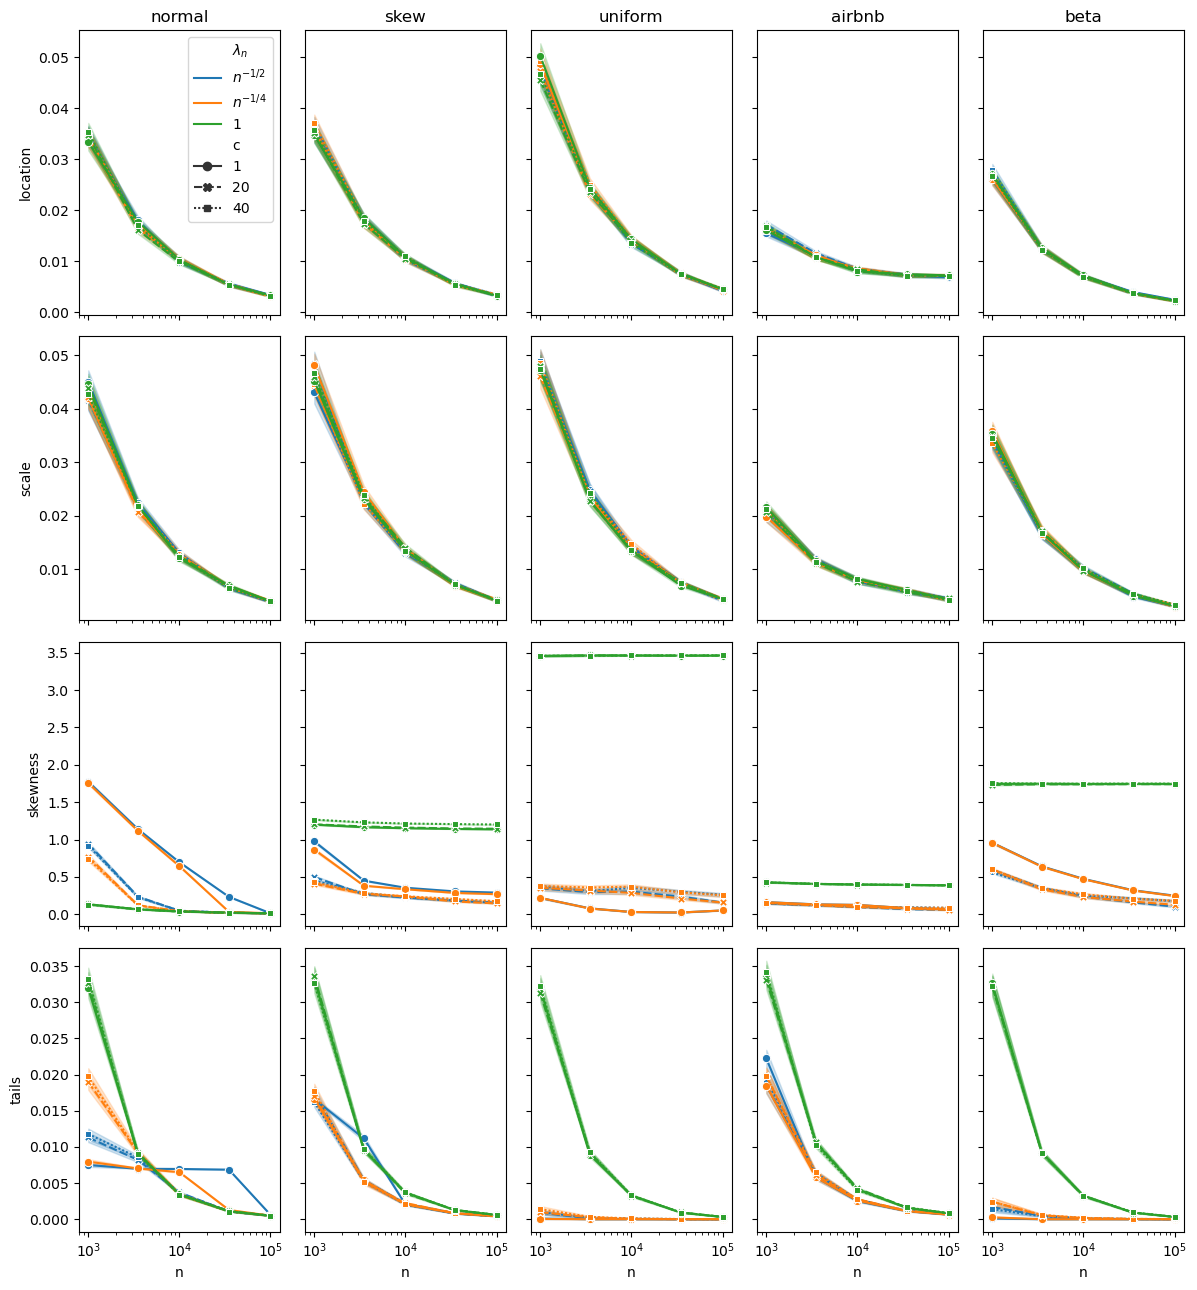

In [35]:
plot_results_parameters(M = 1000, deltas = [0, 0.25, 0.5], figsize = (12,13))

['method', 'JointExp', 'ApproxQuantile', 'unbounded', 'PrivateQuantile', 'DPBoxplot', 'oracle', 'eps', '1', '5']


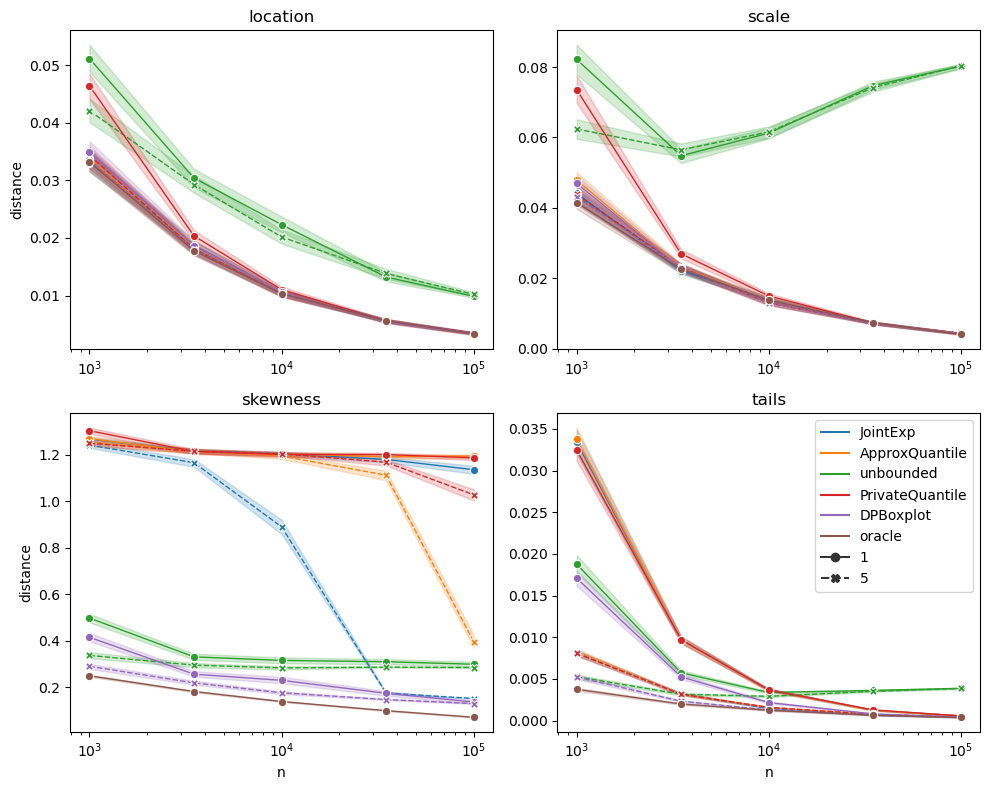

In [9]:
plot_results_slides(figsize=(10,8))